# Tenny's Flight Path Data

In conducting a study like this, it helps to have experimental data available. We can use those data to validate our work and gaining confidence in the tools we use to conduct the research. I did some research and came up with several interesting results.

Bud Tenny conducted an extensive study of indoor model flight paths in his 1968 Symposium article {cite}`tenny1968` and presented a graphical technique for estimating flight time.  Bud managed to get some nice data from actual flights of indoor models. Not much detail is provided on the model making those flights, but Bud shows torque curves, flight path data, and rpm data for his test flights. Let’s explore his findings and use Python to see what we can do with them. 

Bud presented his results as a set of graphs in his symposium article. Staring at those plots is nice, but we need the data behind the plots to do much work with these results. The article included some tabulated results, but most of the results are just graphs, so we seem to be stuck. Or are we?

## Digitizing Graphical Data

I found a nice free desktop application called [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) that lets you take an image of a plot and digitize it with a mouse on your computer. Once done, you can save your curve in a standard comma-separated variable file that you could load into your favorite spreadsheet. I am going to read that file using Python. 

The following code block prepares *Jupyter* so it can access my stored data files.

In [17]:
# page setup block
import os
import sys
projdir = os.path.abspath('../..')
if projdir not in sys.path:
    sys.path.insert(0,projdir)

We need to run this next code block to embed images in the notebook page you are writing:

In [18]:
from IPython.display import Image # to display the images

Displaying an image in a *Jupyter* page is simple. You need t provide the path to the file, relative to the page you are viewing. I keep all images for my research in an assets directory in my project.

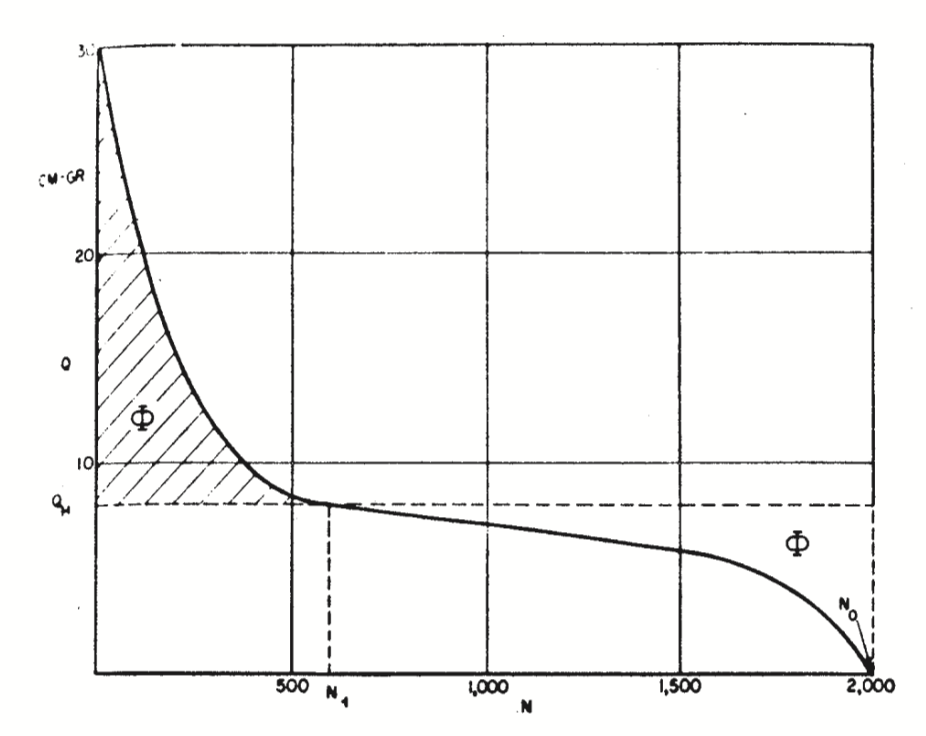

In [19]:
from IPython.display import Image
Image(filename='../../assets/images/torque-curve.png')

In digitizing this curve, I zoomed the image up to full screen, then used *SnagIt*, a screen capture program I have used for years, to capture the image.  Digitizing with *WebPlotAnalyzer* involves defining the axis values to set scaling factors, then using the mouse to pick a series of points along the curve. The data produced is then saved as a CSV file ready to load into a *Jupyter* notebook page. To make the loading process easier, I created a Python function that takes a file name as a parameter and returns the curve data as two lists, one holding x values, and the other y values. Splitting these values this way makes things much easier to process with other Python tools we will see soon. Here is the loading function:

In [20]:
import csv
import numpy as np

def get_points(filename):
    q_pts = []
    with open(filename,'r') as fin:
        raw_data = csv.reader(fin, delimiter=',')
        for row in raw_data:
            q_pts.append(row)
    x = []
    y = []
    for pt in q_pts:
        x.append(float(pt[0]))
        y.append(float(pt[1]))
    nx = np.array(x)
    ny = np.array(y)
    return nx,ny

The first two lines shown provide access to two Python tools that make this seemingly complicated task much easier! The **numpy** package provides powerful tools for manipulating data sets of all kinds and sizes. We only have a few points to deal with here, but **numpy** can handle huge sets of data! The **csv** package handles loading the *CSV* file. It can also be used to create CVS files from data you generate in your code. 

Basically, the **get_points** function code receives the name of a *CSV* data file to process. It reads the file line by line and saves each point into **numpy** arrays holding $x$ and $y$ coordinates of the points you digitized on the image.

*Jupyter* remembers calculations you set up in previous cells, so you can build up your calculations and test your code in short chunks. It is far easier to correct things this way. After we process a cell with a *Python* function, we can use that function in code we write in cells that come later.


### Plotting the Data

What does my digitized data look like? I am not especially interested in looking at a pile of numbers. How about a nice graph of my own? Time for another Python tool:

In [21]:
import matplotlib.pyplot as plt

def show_curve(x,y,title,xlabel,ylabel):
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

The **matplotlib** tool provides plotting capabilities that help you visualize your data. Although we will only show simple plots here, **matplotlib** can generate very fancy displays of three-dimensional data if needed. 

The **show_curve** display function created above accepts two point coordinate lists, a title, and labels for each axis and displays the result. This is a quick and easy way to see your data rather than looking at all those ugly numbers! Here is how we use these new functions:

In [22]:
datadir = os.path.join(projdir,"mmtime","data")

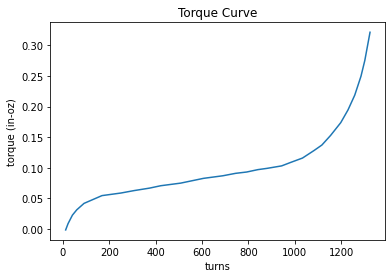

In [23]:
torque_curve = os.path.join(datadir,"torque-curve.csv")
q_nx, q_ny = get_points(torque_curve)
show_curve(q_nx, q_ny, 
        "Torque Curve", "turns", "torque (in-oz)")

**matplotlib** flipped this curve from the original, but it shows the same data. The curve is flipped, since **matplotlib** thinks the numbers on the x-axis should increase. I can fix that later. In ancient times, researchers had to generate graphs like this manually! 

We now have a process we can use to capture data from any source where we can get an image of a curve. Many research articles show figures with data curves, but space limitations preclude including tabulated data. This entire process is a big part of the new *Data Science* field that seeks to mine data from multiple sources and generate new useful information from that data! As you might expect, the Python tools we are demonstrating here are very popular in data science research!

## Propeller Speed Data

We can now look at the propeller speed data:

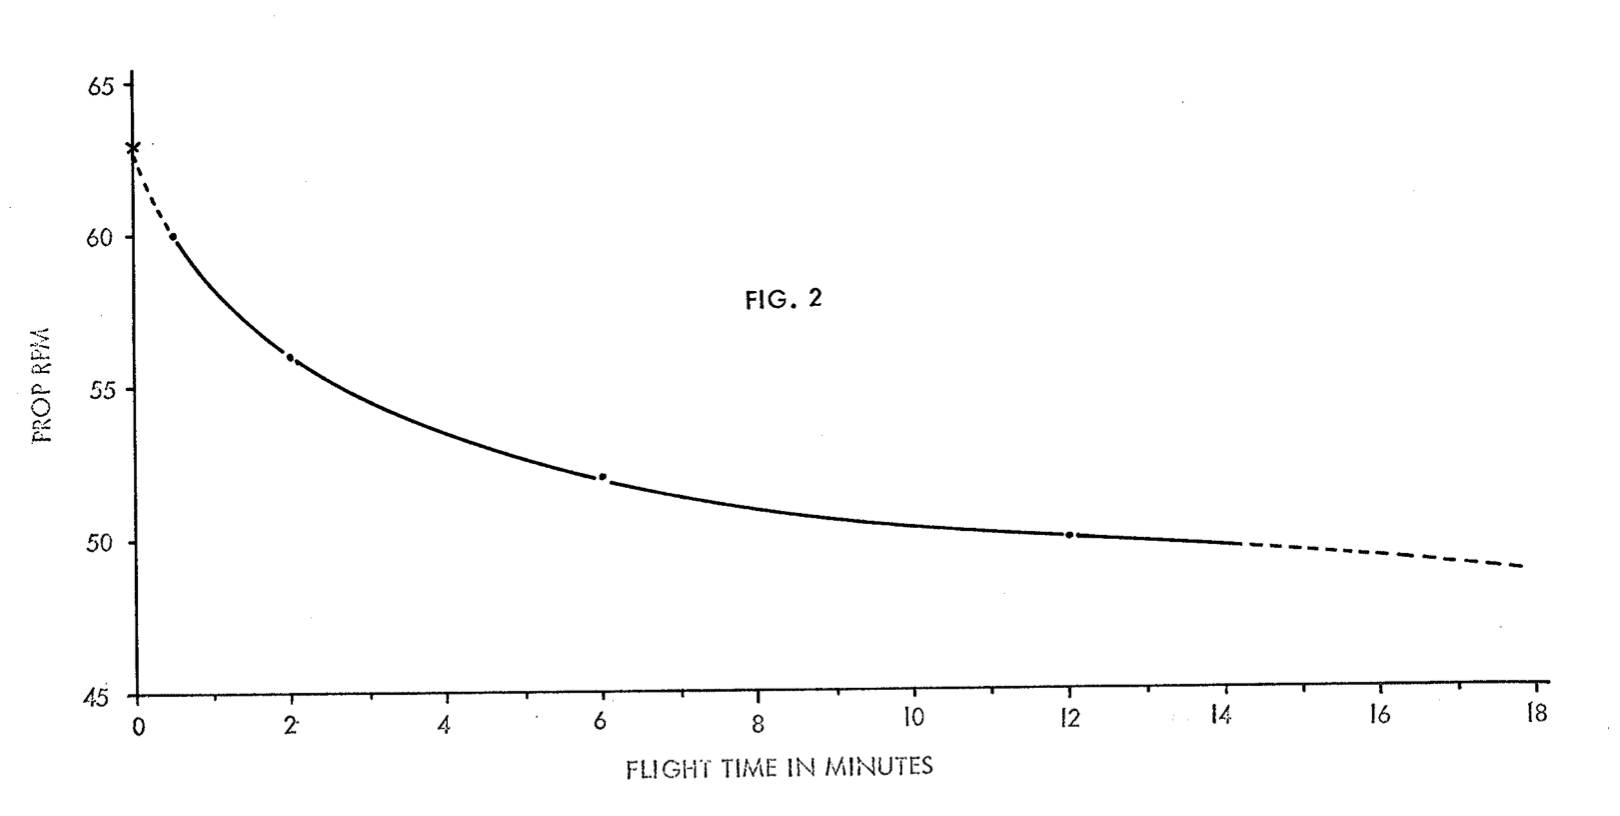

In [24]:
rpm_image = os.path.join(datadir,"prop-rpm.png")
Image(filename=rpm_image)

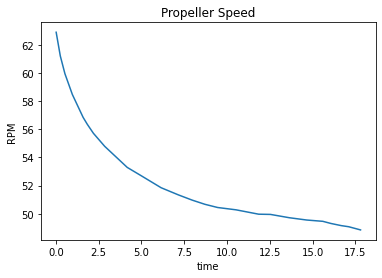

In [25]:
rpm_csv = os.path.join(datadir,"prop-rpm.csv")
rpm_x, rpm_y = get_points(rpm_csv)
show_curve(rpm_x, rpm_y, "Propeller Speed", "time", "RPM")

## Flight Profile Data

Tenny recorded the height of the model as a function of time. This was a tedious process involving a balloon and multiple readers trying to gauge the height of the model and balloon then reading markings on the string holding the balloon! 

Here is Tenny's graph:

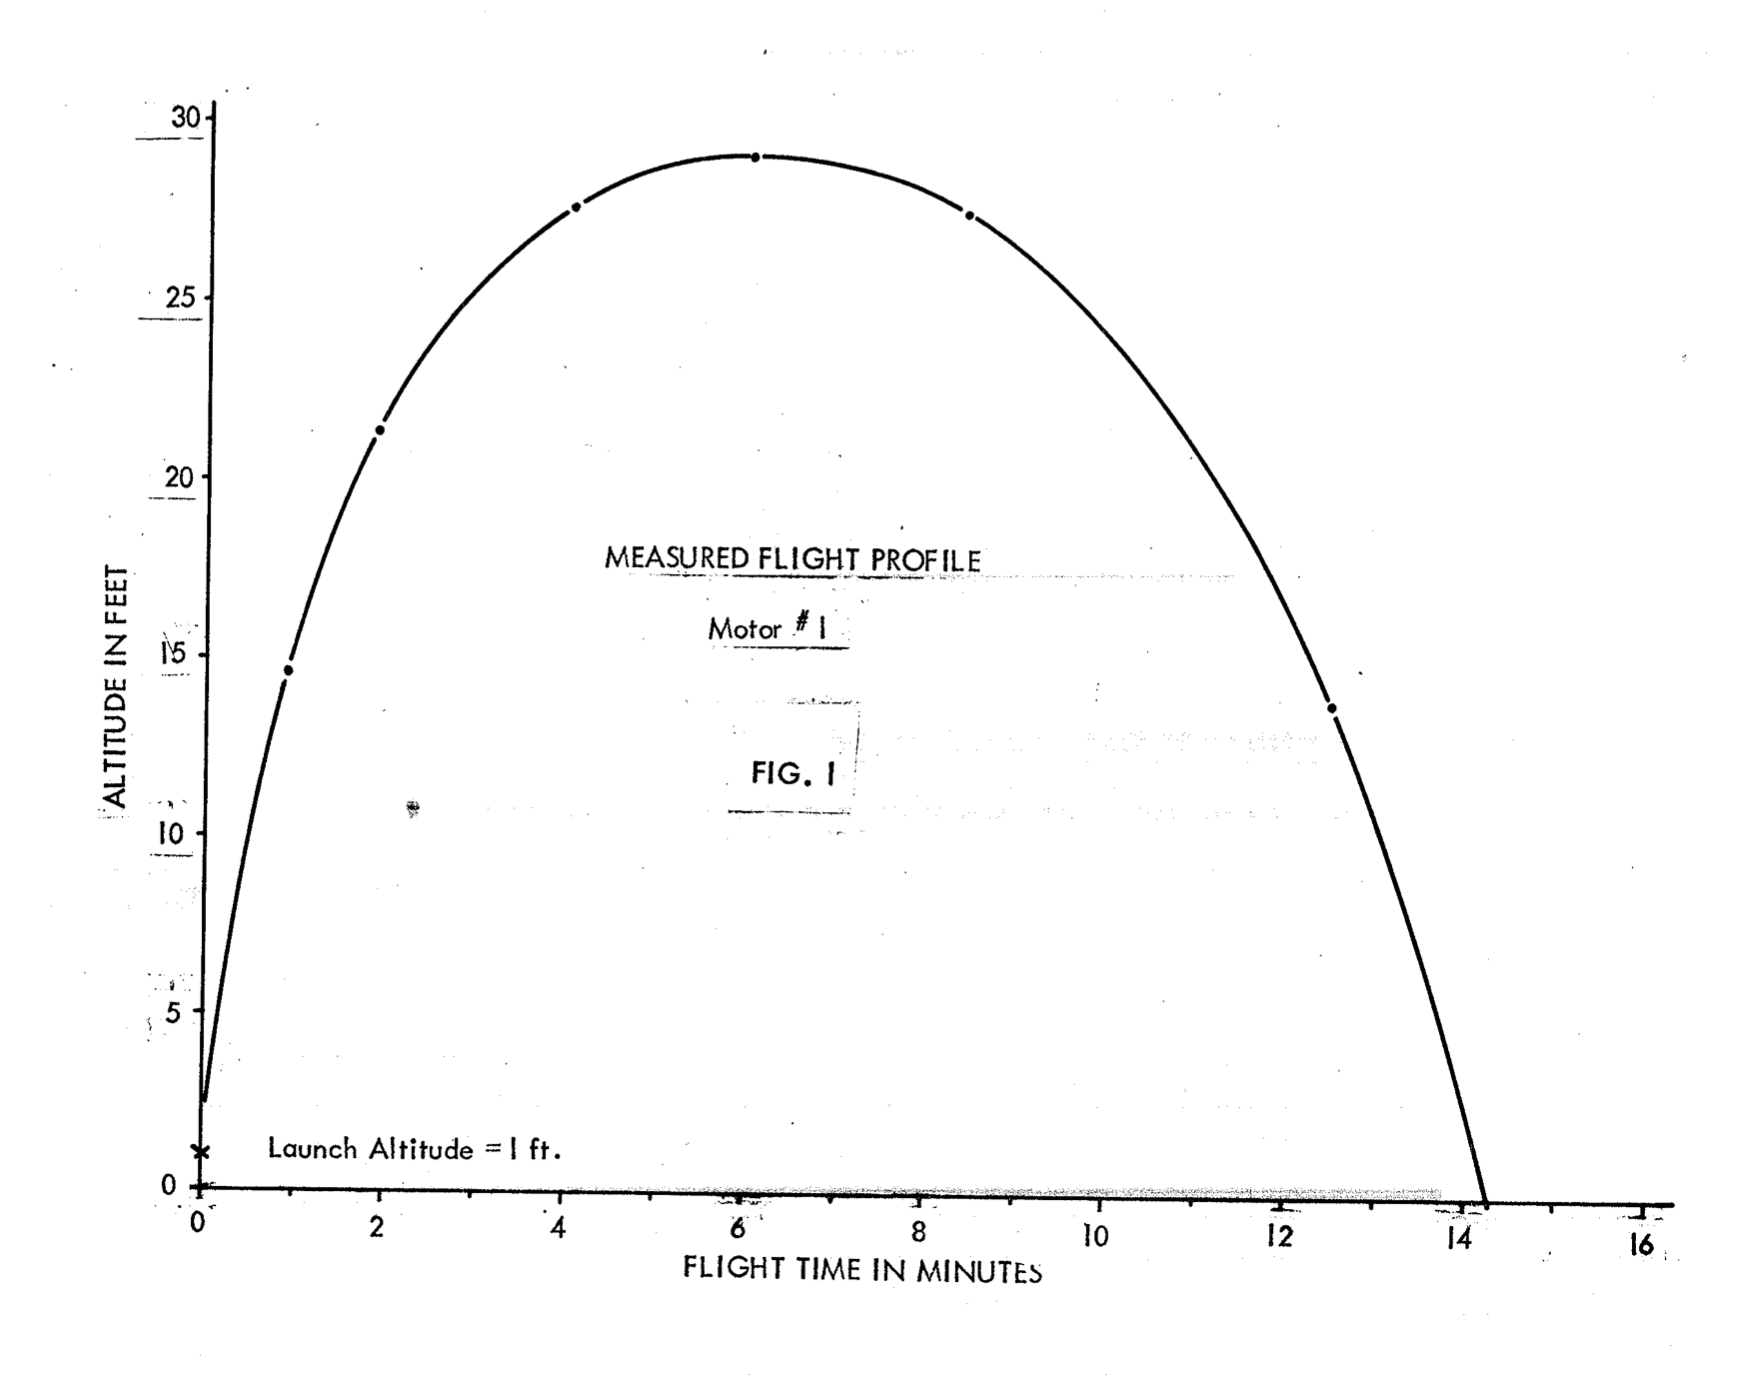

In [26]:
fp_image = os.path.join(datadir,"flight-profile.png")
Image(filename=fp_image)

Here is our digitized result:

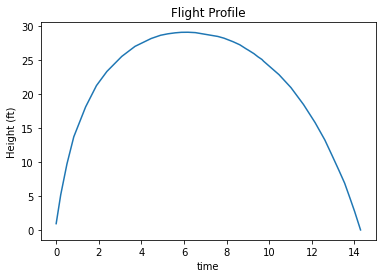

In [27]:
fp_csv = os.path.join(datadir,"flight-profile.csv")
Image(filename=fp_image)
fp_x, fp_y = get_points(fp_csv)
show_curve(fp_x, fp_y, "Flight Profile", "time", "Height (ft)")

## Processing the Data

Once we have the data in digital form, we can do some amazing things. However, the data currently is just a pile of numbers. We can turn those numbers into a Python function by using a curve fitting scheme. Here is some code that will turn our numbers into a cubic spline function that we can use to get a data at any point along the curve:

In [28]:
from scipy import interpolate

def fit_curve(x, y): # using a cubic spline
    fit = interpolate.CubicSpline(x,y)
    return fit

**scipy** is yet another useful Python tool that provides a set of standard mathematical operations you can use. In this case, we get a function back that we can use to get a value from the curve from any input value along the x-axis. The function will even return values beyond the range of your input data, but doing this extrapolation is risky. You might not like the results.
We create a curve fit function by passing the curve points to our fitting routine:


### Torque as a Function of Turns (q_n)


We have a minor problem with the torque curve. The raw data **x** axis shows turns remaining, which is a decreasing number. The curve fit routines need increasing values. To cure this, I am going to change the values to turns expended by subtracting the input data from the max turns in our digitized data set. **numpy** makes this is easier than it sounds. If you set up arithmetic operations using arrays, **numpy** does the math on all the elements of the array. This significantly streamlines your code:

In [29]:
max_turns = q_nx[0]
q1_nx = max_turns - q_nx
q_n = fit_curve(q1_nx, q_ny)

Here, the second line flips the turn values so they show turns expended, not turns left. numpy makes processing lists of numbers easy! 

**q_n** is a new function we can use to get torque for any value of turns at any point alone the curve. With it, we can generate a new plot using as many points as we like. 

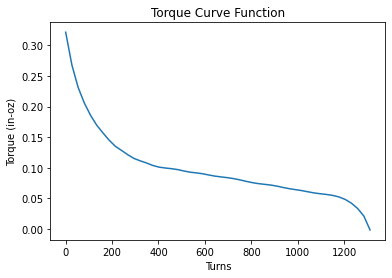

In [30]:
n_sample = np.linspace(q1_nx[0], q1_nx[-1], 50)
q_sample = q_n(n_sample)
show_curve(n_sample, q_sample, 
           "Torque Curve Function", 
           "Turns", "Torque (in-oz)")

In this snippet, I create a sample set of 50 turn values evenly distributed between the end point **q1_nx** values from my data, then feed that set of numbers to the curve fit function **q_n** generated from the original data points. **numpy** gives back a new set of points that I can plot.

I can use the curve fit function, which normally gives you torque for an input turn count, to get a turn count for some input torque. Here is an example of how this is done when we know the launch torque and want to find out what turn value on the torque curve would produce that torque:

In [31]:
launch_torque = 0.2
launch_turns  = q_n.solve(y=launch_torque)
print (launch_turns)

[87.77567122]


### Finding the Average Torque

Now, let's find the average torque from this curve. The average value of any function is defined as the integral of that function divided by the length of the interval.  We need to find the area under the curve and locate the point where half of that area is on each side of that point.

In [32]:
ni = n_sample
qi = q_sample

We will calculate the area under this curve using a simple approximation. The area of a strip bounded by any two adjacent points along the curve is approximately 1/2 of the sum of the torque values of each point times the increment in turns between those two points. The total area is the sum of the areas of each strip.

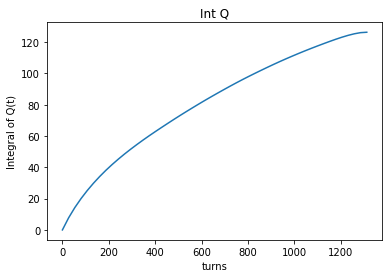

In [33]:
dn = ni[-1]/50
ai = [0]
for i in range(len(ni)-1):
    da = (qi[i+1] + qi[i])*dn/2
    ai.append(ai[i]+da)
show_curve(ni,ai,"Int Q", "turns", "Integral of Q(t)")

From this curve, we see the total area under the torque curve is:

In [34]:
area = ai[-1]
area

126.27645550050222

From the definition of *average torque* we can find the value by dividing this number by the interval length, which is 1200 for this data set.

In [35]:
area / 1200

0.10523037958375185

We are interested in the turn value where the area is one half of this total. Rather than resort to complicated scheme to figure this out, I am just going to search for the turn value where the area just goes past this torque value and use that.

In [18]:
for i in range(len(ni)):
    if ai[i]> ai[-1]/2:
        print("Average Torque is",qi[i], " which happened at turn count:",ni[i])
        break
        

Average Torque is 0.09977135471227384  which happened at turn count: 428.3438410821636


The two results are close. Obviously, a better function integration routine would give us a more accurate average torque value. This experiment just shows ways you can get quick results using Python.

### RPM as a Function of Time (n_t)

We use a similar scheme to generate a function that will deliver RPM as a function of time:

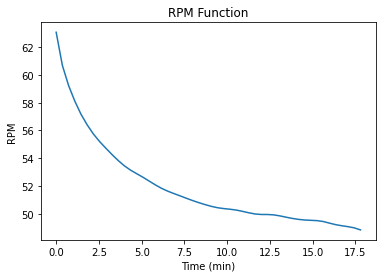

In [36]:
fn_t = fit_curve(rpm_x, rpm_y)

max_time = rpm_x[-1]
t_samples = np.linspace(0, max_time, 50)
rpm_samples = fn_t(t_samples)
show_curve(t_samples, rpm_samples, "RPM Function", "Time (min)", "RPM")

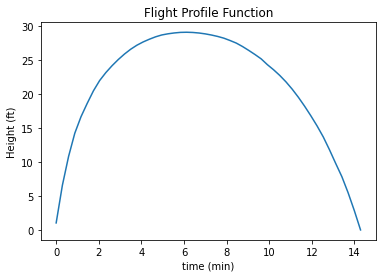

In [37]:
flight_time = fp_x[-1]  # last point on the flight profile time axis
fh_t = fit_curve(fp_x, fp_y)
t_samples = np.linspace(0,flight_time,50)
h_samples = fh_t(t_samples)
show_curve(t_samples, h_samples, "Flight Profile Function","time (min)", "Height (ft)")

At this point, we have a scheme to generate data curve functions we can use to do further analysis. Let's see examples of using this new capability to generate something new.

## Generate New Data

Once we have our functions available, we can generate new data.

### Vertical velocity

Now, let’s find the vertical velocity of the model by differentiating the height function. This is a numerical differentiation since we do not really have access to an equation defining the curve. I followed the same process outlines above to get a curve fit function fh_t for height as a function of time.

In [38]:
t_samples = np.linspace(0,14.5,50)
fdh_t = fh_t.derivative()
dhdt_pts = fdh_t(t_samples)

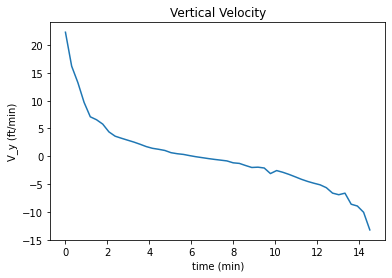

In [39]:
show_curve(t_samples,dhdt_pts,"Vertical Velocity","time (min)", "V_y (ft/min)")

Digitized data is often a bit lumpy. We see the effects of that in this curve. There are ways to smooth this kind of data, but doing so might introduce more errors. In this case, smoothing the original data might help. We will see how to do that in the next section.

Tenny included some tabulated data on vertical speed. Let's see how this curve compares with his data:

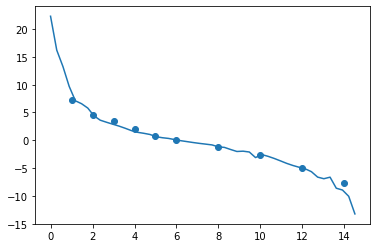

In [40]:
time_samples = np.array(
    [1,2,3,4,5,6,8,10,12,14]
)
time_values = np.array(
    [7.3,4.5,3.5,2.0,0.8,
     0,-1.2,-2.7,-5.0,-7.7])
fitted_dhdt = fdh_t(t_samples)
plt.plot(t_samples, fitted_dhdt)
plt.scatter(time_samples, time_values)
plt.show()

This kind of result gives you confidence in your analytical tools.

### Propeller Power

Let’s try something a bit more complicated. We have shown how to generate functions that represent our input data. I want to see the propeller power curve, but I do not have that data available. What I do have is propeller speed as a function of time, and torque as a function of turns.  If I integrate the propeller speed function I can get turns as a function of time, then pass that into the torque function to get torque as a function of time. I can combine the results to get the power I want using this formula:

\begin{equation}
P = 2\pi n Q
\end{equation}

where $n$ is the prop speed (rpm) and $Q$ is the torque. 

The torque data we have is torque/turns and we need torque/time. 

Let's review the functions we have generated:

- torque as a function of turns (**q_n**)

\begin{equation}
q_n = Q(n)
\end{equation}

- RPM as a function of time (**fn_t**)

\begin{equation}
rpm_t = R(t)
\end{equation}

- turns as a function of time (**n_t**)

\begin{equation}
n_t = N(t) 
\end{equation}

So, if we have a given time $t$ then

\begin{equation}
q_t = Q(R(t))
\end{equation}

We have rpm data measured over time. If we integrate that function we will get a function for turns as a function of time. 

In [41]:
import math

ft_t = fn_t.antiderivative()
turn_samples = ft_t(t_samples)
def fq_t(time):
    turns = ft_t(time)
    q = q_n(turns)
    return q
q_samples = fq_t(t_samples)
P_samples = 2 * math.pi * \
    rpm_samples * q_samples

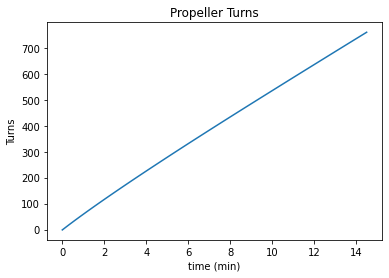

In [42]:
ft_t = fn_t.antiderivative()
turn_samples = ft_t(t_samples)
show_curve(t_samples, turn_samples, 
           "Propeller Turns", 
           "time (min)", "Turns")

The last point on this curve is the remaining turns after the airplane landed:

In [43]:
print("Flight turns =",turn_samples[-1])

Flight turns = 759.6862469931604


This curve may look straight, but it is not. The interesting thing that it shows is how many turns were used in this flight, 749 from that last number printed. According to Tenny's article, the motor was wound to  about 1240 turns (0.2 inch-oz of torque, and landed with about 500 turns remaining. This analysis said it would have landed with 1240-759 = 481 turns! Not bad!

We can now use these two functions to get our new torque/time function:

In [44]:
def fq_t(time):
    turns = ft_t(time)
    q = q_n(turns)
    return q

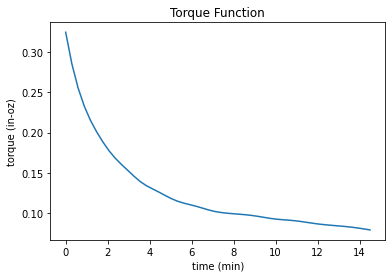

In [45]:
q_samples = fq_t(t_samples)
show_curve(t_samples, q_samples, "Torque Function", "time (min)","torque (in-oz)")

Now we can get our power curve:

In [46]:
P_samples = 2 * math.pi * rpm_samples * q_samples

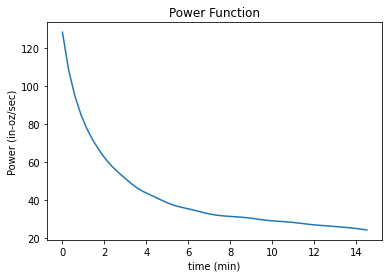

In [47]:
show_curve(t_samples, P_samples,"Power Function", "time (min)","Power (in-oz/sec)") 

I think you can see how useful these techniques can be in conducting an analysis. The combination of *Jupyter* and Python lets you experiment with things, and see results quickly. This speeds up your work significantly!

Walter Erbach, in a paper we will look at later, lamented that he had to analyze "terrifying yards of tabulated results" to conduct his research. Thankfully, those days are over!"

At this point, we have introduced most of the tools needed to conduct this study. In the next sections we will work through the development of the equations included in McLean's paper, and show one more powerful Python tool: **sympy** which is the tool you wish you had when you were first working through your math courses in school!